In [1]:
from fit_modelSignal import *
from fit_modelControl import *
from scipy.optimize import minimize
import numdifftools as nd

from utility_commonPlot import *

from timeit import default_timer as timer

In [2]:
baseDir = common.getBaseDirectory()
shaping = True

if shaping:
    X0 = np.load(baseDir + "data/templates/shaping_signalRegion/X_.npy")
    #X1 = np.load(baseDir + "data/templates/shaping_controlRegion/X_.npy")
else:
    X0 = np.load(baseDir + "data/templates/counting_signalRegion/X_.npy")
    #X1 = np.load(baseDir + "data/templates/counting_controlRegion/X_.npy")

    
Y0 = np.sum(X0,axis=1) + 0.1
#Y1 = np.sum(X1,axis=1) + 0.1

model0 = PredictiveModel_Signal (X0,shaping)
#model1 = PredictiveModel_Control(X1,shaping)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zihengchen/Documents/Analysis/workplace/data/templates/shaping_signalRegion/X_JESDown.npy'

# define Model

In [5]:
def loss (param):
    y0 = model0.predict(param)
    y1 = model1.predict(param)
    loss  = np.sum( (y0-Y0)**2/(2*Y0) )
    loss += np.sum( (y1-Y1)**2/(2*Y1) )
    
    # slt1 = np.array([0,1,2,3, 4,5,6,7, 8,9,10,11, 12,13,14,15])
    # slt2 = np.array([0,1])
    # loss  = np.sum( (y0[slt1]-Y0[slt1])**2/(2*Y0[slt1]) )
    # loss += np.sum( (y1[slt2]-Y1[slt2])**2/(2*Y1[slt2]) )
    
    loss += np.sum( (param[3:]**2)/2  )
    return loss

param0 = np.array([0.107,0.108,0.1090] + [0.0]*22)
start = timer()
result = minimize( loss, param0, method='SLSQP', bounds = [(0,1)]*3 + [(-1,1)]*22 )
end   = timer()
print(result.x[:3])

print('fitting time = {:6.4f} ms'.format( (end-start)*1000 ))

[0.10800915 0.10800741 0.10802766]
fitting time = 739.8295 ms


In [6]:
start = timer()
hcalc = nd.Hessian(loss, step=1e-4, method='central')
hess  = hcalc( result.x )
end   = timer()
hessinv = np.linalg.inv(hess)
sig   = np.sqrt(hessinv.diagonal())
cor   = hessinv/np.outer(sig, sig)
loss0 = loss(result.x)
print('hessian time = {:6.4f} ms'.format( (end-start)*1000 ))
# commonp.showParameterCovMat(cor,sig)
# plt.savefig('../plots/fit/cov_woshape_wocontrol.png',dpi=300)

hessian time = 1521.0515 ms


In [7]:
for i in range(sig.size):
    c,s = result.x[i], sig[i]
    print('{:7.4f} +/- {:6.4f}'.format(c,s))

 0.1080 +/- 0.0008
 0.1080 +/- 0.0008
 0.1080 +/- 0.0018
-0.0013 +/- 0.9989
-0.0030 +/- 0.9973
-0.0094 +/- 0.4259
 0.0161 +/- 0.9160
 0.0171 +/- 0.7570
-0.0065 +/- 0.4363
 0.0048 +/- 0.9871
 0.0020 +/- 0.3680
 0.0016 +/- 0.1648
-0.0022 +/- 0.1716
 0.0093 +/- 0.7773
 0.0025 +/- 0.6431
 0.0023 +/- 0.6420
 0.0117 +/- 0.3603
-0.0107 +/- 0.2926
 0.0028 +/- 0.1832
 0.0028 +/- 0.3406
 0.0063 +/- 0.2593
 0.0010 +/- 0.1254
-0.0011 +/- 0.2270
 0.0011 +/- 0.0290
-0.0038 +/- 0.6394


## Appendix A: Do NLL Scan

In [8]:
lossesList = []
labels = commonp.sysLabelsName()
for i in range(3,sig.size):
    c,s = result.x[i], sig[i]
    def loss (param):
        param[i] = theta
        y0 = model0.predict(param)
        y1 = model1.predict(param)
        loss  = np.sum( (y0-Y0)**2/(2*Y0) )
        loss += np.sum( (y1-Y1)**2/(2*Y1) )
        loss += np.sum( (param[3:]**2)/2  )
        return loss
    
    thetas = np.arange(-1,1.0001,0.05)
    losses = []
    for theta in thetas:

        param0 = result.x
        result = minimize( loss, param0, method='SLSQP', bounds = [(0,1)]*3 + [(-1,1)]*22 )
        losses.append( loss(result.x) -loss0 )
    losses = np.array(losses)
    lossesList.append(losses)

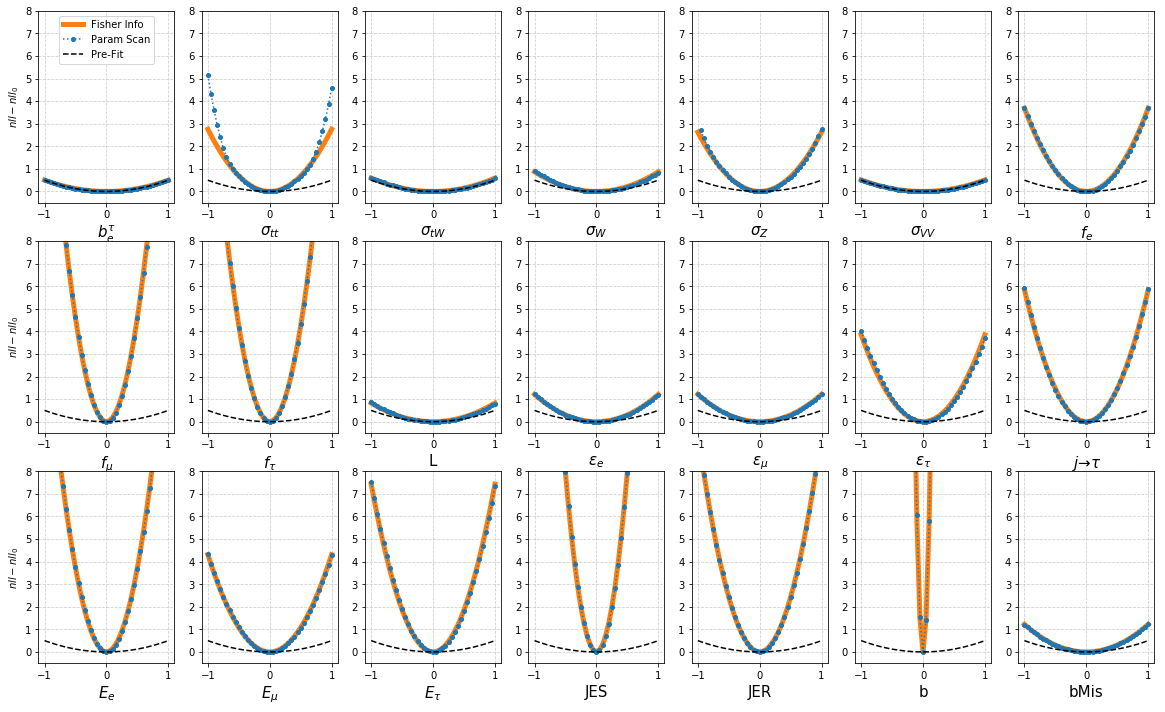

In [34]:
plt.figure(facecolor='w',figsize=(20,12))

for i in range(1,22):
    c,s = result.x[i+3], sig[i+3]
    
    losses = lossesList[i]
    
    plt.subplot(3,7,i)
    slt = losses<20
    plt.plot(thetas, (thetas/s)**2/2, c='C1',lw=5, label='Fisher Info')
    plt.plot(thetas[slt], losses[slt], marker='.',markersize=8, c='C0',linestyle=':',label='Param Scan')
    plt.plot(thetas, thetas**2/2, color='k',linestyle='--', label='Pre-Fit')
    
    if i ==1:
        plt.legend(loc='upper center')
    plt.grid(linestyle='--',alpha=0.6)
    
    plt.xlabel(labels[i+3],fontsize=15)
    if i%7==1:
        plt.ylabel(r'$nll-nll_0$')
    plt.ylim(-0.5,8)
plt.savefig('../plots/fit/scan.png',dpi=300)

In [23]:
20%7

6